In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import spconv.pytorch as spconv
import matplotlib.pyplot as plt
import mytools
import mymodels

# Select and load testing data

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Read pandas dataframe with all information about sparse training tensors
file_loc = '/home/majd/sparse_testing_arrows/'
st_info = pd.read_pickle(file_loc+'sparse_tensor_info.pk')
st_info

,dir,offset
0,"[-0.19599886999474228, 0.8528593436875164, 0.4...","[0, 0, 0]"
1,"[0.22486356846184327, 0.35994540251067464, -0....","[0, 0, 0]"
2,"[-0.5471225637250694, -0.14112552598636538, -0...","[0, 0, 0]"
3,"[0.7308492773130751, 0.6825335033937229, -0.00...","[0, 0, 0]"
4,"[0.5098176584027287, 0.580607269703131, 0.6348...","[0, 0, 0]"
...,...,...
995,"[-0.4095412390125088, -0.4509608287682188, -0....","[0, 0, 0]"
996,"[-0.5781674722330667, 0.645906447543276, -0.49...","[0, 0, 0]"
997,"[-0.1971656435162908, 0.9244088560972281, 0.32...","[0, 0, 0]"
998,"[-0.18436980648744, 0.7827432432689708, 0.5944...","[0, 0, 0]"


In [4]:
# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc = file_loc, st_info = st_info)

# Create DataLoader
batch_size = 256
test_dataloader = DataLoader(MyDataset, batch_size=batch_size, shuffle=True)

# Print tensor shapes
for X_plot, y_plot, offset_plot in test_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break
    
#Record shape of voxel grid
grid_shape = X_plot.shape[1:4]
print("Voxel grid shape: " , grid_shape)


Shape of X [N, C, H, W, D]: torch.Size([256, 120, 120, 120, 1])
Shape of y: torch.Size([256, 3]) torch.float32
Offsets:  torch.Size([256, 3])
Voxel grid shape:  torch.Size([120, 120, 120])


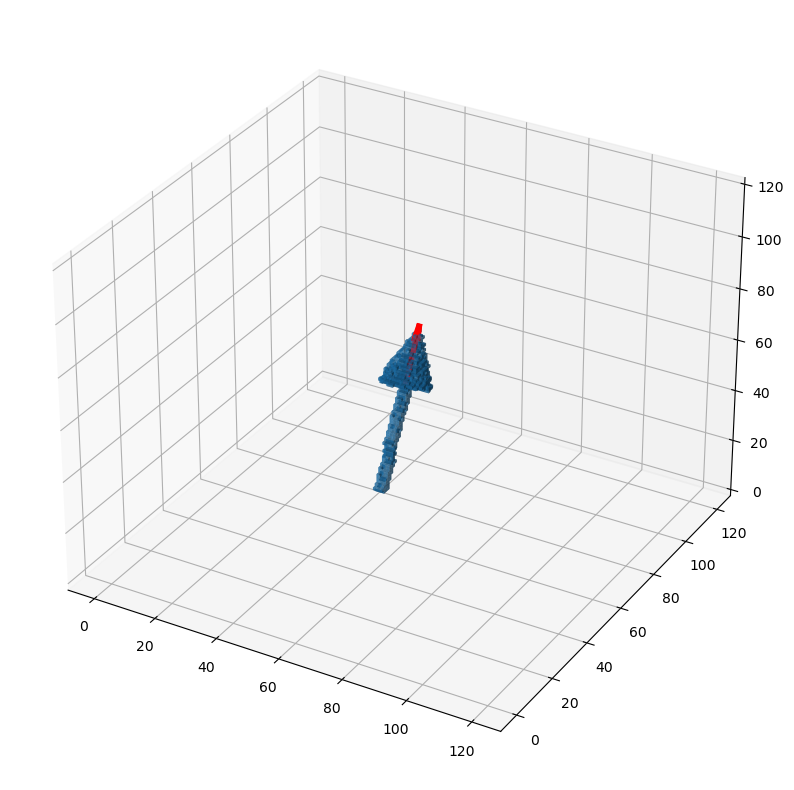

In [5]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = mytools.voxel_grid['eff_l']
# Voxel size in cm
vox_l = mytools.voxel_grid['vox_l']

#Convert to dense, reshape and convert to numpy
X_plot = X_plot.to_dense().reshape(-1, 1, 120, 120, 120).numpy()

index = 2
mytools.plot_tensor_dir(tensor = X_plot[index], start = offset_plot[index].numpy(), direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)



# Test HSCDC CNN Model

In [6]:
# Load the model
model_HSCDC = torch.load('../3D_Heteroscedastic_Convnet_models/3D_HSCDC_arrows.pt').to(device)

# Obtain predictions and Labels
v_pred_HSCDC, K_pred_HSCDC, v_true_HSCDC, off_true_HSCDC = mytools.test_HSCDC(test_dataloader,model_HSCDC,device)

598.2127


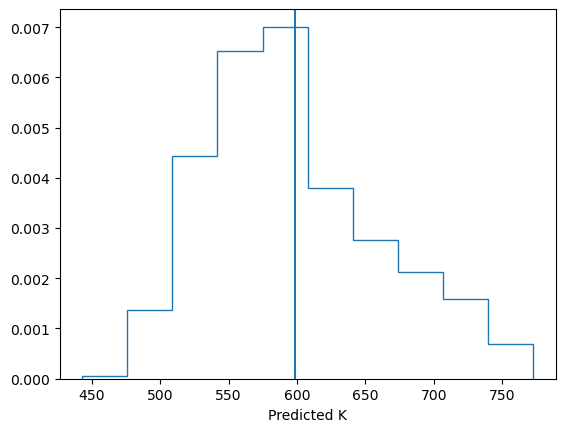

In [7]:
# Plot a histogram of the predicted kappa values
plt.hist(K_pred_HSCDC.flatten().numpy(), density=True, histtype='step')
plt.axvline(np.mean(K_pred_HSCDC.flatten().numpy()),label="Mean")
plt.xlabel("Predicted K")
print(np.mean(K_pred_HSCDC.flatten().numpy()))

In [8]:
print(np.min(K_pred_HSCDC.flatten().numpy()))

442.9717


In [9]:
# Compute the cosine similarity loss using the mean predictions from the HSCDC model
HSCDC_Loss = mytools.CSloss(v_pred_HSCDC, v_true_HSCDC)
HSCDC_Loss

tensor(-0.9992)

In [10]:
# Now compute the Loss versus efficiency cuts in K_pred (the uncertainty prediction in the HSCDC model)
CS = nn.CosineSimilarity()

# Percent of data that is cut
eff = np.arange(0,90,1)
# Coresponding percentiles
pers = np.percentile(K_pred_HSCDC,eff)

# Compute loss at each percentile
eff_loss = []
# Compute Head/Taill eff at each percentile
HT_eff = []
# Compute axial performance at each percentile
AP = []

for per in pers:
    
    T_vals = (K_pred_HSCDC >= per).flatten()
    v_pred_cut = v_pred_HSCDC[T_vals]
    v_true_cut = v_true_HSCDC[T_vals]
    
    eff_loss += [mytools.CSloss(v_pred_cut, v_true_cut)]
    
    vals = CS(v_pred_cut,v_true_cut)
    HT_eff += [torch.sum(vals>0).item() / len(vals)]
    AP += [torch.mean(-1.0*torch.abs(CS(v_pred_cut,v_true_cut)))]

    

Text(0, 0.5, 'Cosine Similairity Loss')

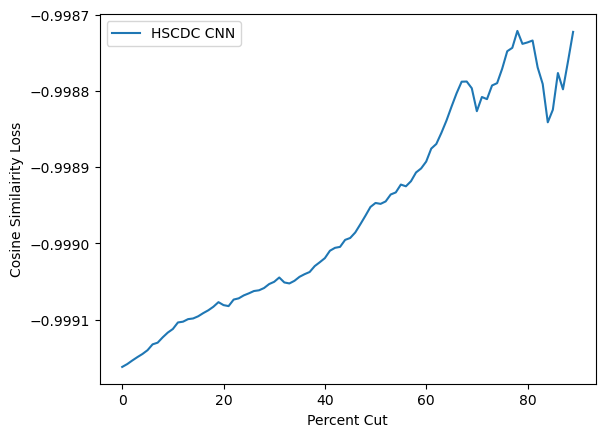

In [11]:
# Visualize how the predictions can be improved by cutting on Kappa
plt.plot(eff,eff_loss, label = "HSCDC CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Cosine Similairity Loss")

Text(0, 0.5, 'Head Tail Efficiency')

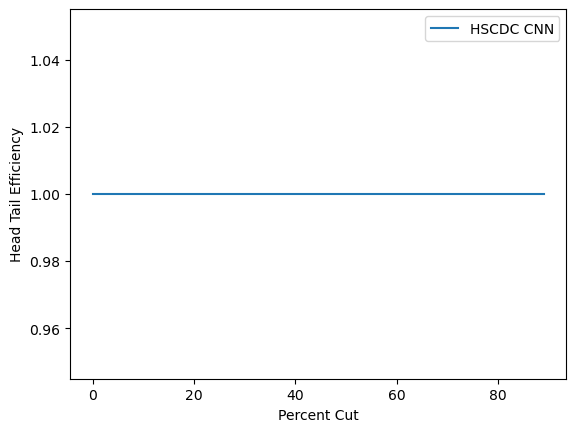

In [12]:
# Visualize how the Head/Tail efficiency can be improved by cutting on Kappa
plt.plot(eff,HT_eff, label = "HSCDC CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Head Tail Efficiency")

Text(0, 0.5, 'Axial Performance')

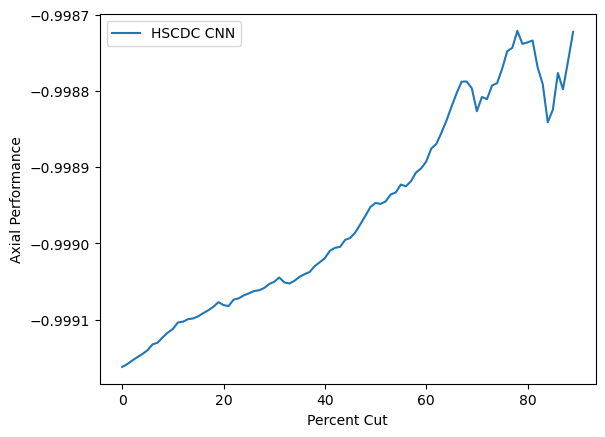

In [13]:
# Visualize how the axial performance can be improved by cutting on Kappa
plt.plot(eff,AP, label = "HSCDC CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Axial Performance")

# Test Regular CNN Model

In [14]:
# Load the regular CNN model
model_CNN = torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN_arrows.pt').to(device)
# Obtain predictions and labels
v_pred_CNN, v_true_CNN, off_true_CNN = mytools.test_CNN(test_dataloader,model_CNN,device)

In [15]:
# Compute the cosine similairity loss, we cannot make efficiency cuts here
CNN_Loss = mytools.CSloss(v_pred_CNN, v_true_CNN)
CNN_Loss

tensor(-0.9996)

In [16]:
# Compute the axial cosine similairity loss, we cannot make efficiency cuts here
CNN_AP_loss = torch.mean(-1.0*torch.abs(CS(v_pred_CNN,v_true_CNN)))
CNN_AP_loss

tensor(-0.9996)

In [17]:
# Compute the Head/Tail efficiency, we cannot make efficiency cuts here
vals = CS(v_pred_CNN,v_true_CNN)
CNN_HT_eff = torch.sum(vals>0).item() / len(vals)
CNN_HT_eff

1.0

Text(0, 0.5, 'Cosine Similairity Loss')

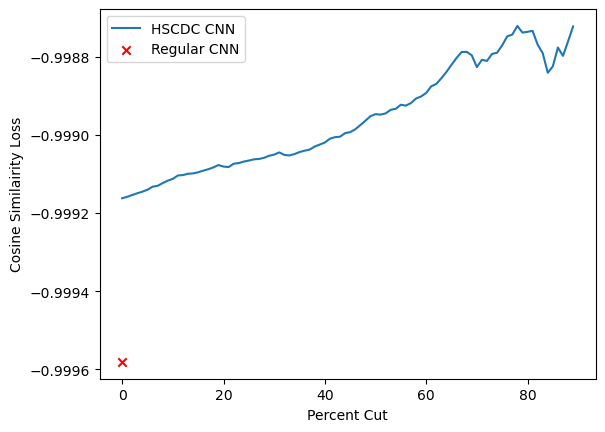

In [18]:
plt.plot(eff,eff_loss, label = "HSCDC CNN")
plt.scatter([0],[CNN_Loss], marker="x", color = 'r', label = "Regular CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Cosine Similairity Loss")

Text(0, 0.5, 'Axial Performance')

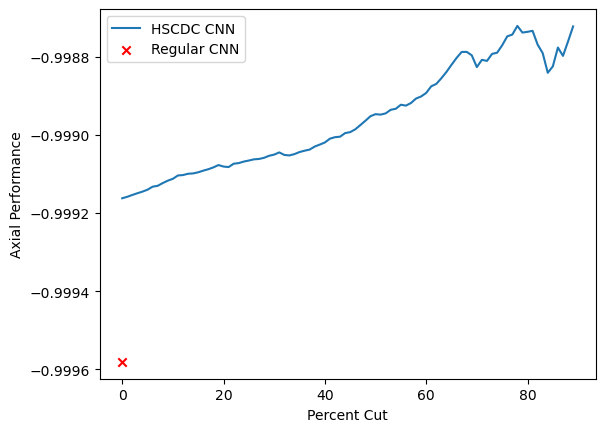

In [19]:
plt.plot(eff,AP, label = "HSCDC CNN")
plt.scatter([0],[CNN_AP_loss], marker="x", color = 'r', label = "Regular CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Axial Performance")

Text(0, 0.5, 'Head Tail Efficiency')

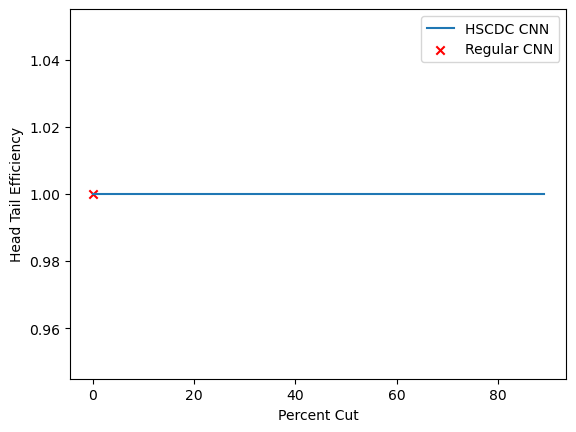

In [20]:
plt.plot(eff,HT_eff, label = "HSCDC CNN")
plt.scatter([0],[CNN_HT_eff], marker="x", color = 'r', label = "Regular CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Head Tail Efficiency")